### Chapter 16: Reduce overfitting with Drpout Regularization

In [1]:
!ls

Checkpoint-Neural-Network.ipynb  iris.data.2			 sonar.all-data
Deep-learning-day1.ipynb	 model_plot.png			 Weights
Deep-learning-projects.ipynb	 Models
Dropout-Chapter16.ipynb		 pima-indians-diabetes.data.csv


In [7]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.optimizers import SGD
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset
dataframe = pd.read_csv('sonar.all-data', header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:,0:60].astype(float)
Y = dataset[:,60]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

# baseline
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(60, input_dim=60, kernel_initializer='normal', activation='relu'))
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # compile model
    sgd = SGD(learning_rate=0.01, momentum=0.8, decay=0.0, nesterov=False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=300, batch_size=16, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print('Baseline: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))

Baseline: 86.50% (4.81%)


### using Dropout with the visible layer

In [10]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset
dataframe = pd.read_csv('sonar.all-data', header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:,0:60].astype(float)
Y = dataset[:,60]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# dropout in the input layer with weight constraint
def create_model():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(60,)))
    model.add(Dense(60, kernel_initializer='normal', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dense(30, kernel_initializer='normal', activation='relu',W_constraint=maxnorm(3)))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # compile model
    sgd = SGD(learning_rate=0.01, momentum=0.8, decay=0.0, nesterov=False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=300, batch_size=16, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print('Baseline: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))

Baseline: 86.50% (4.81%)


### using Dropout on Hidden layers

In [11]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset
dataframe = pd.read_csv('sonar.all-data', header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:,0:60].astype(float)
Y = dataset[:,60]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# dropout in hidden layers with weight constraint
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(60, input_dim=60, kernel_initializer='normal', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(30, kernel_initializer='normal', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    sgd = SGD(learning_rate=0.1, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='binary_crossenrtopy', optimizer=sgd, metrics=['accuracy'])
    return model
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=300, batch_size=16, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print('Baseline: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))

Baseline: 86.50% (4.81%)


### Chapter 17: lift performance with learning rate schedules

In [12]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data

--2020-03-01 15:32:25--  http://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76467 (75K) [application/x-httpd-php]
Saving to: ‘ionosphere.data’

ionosphere.data     100%[===================>]  74,67K  32,5KB/s    in 2,3s    

2020-03-01 15:32:28 (32,5 KB/s) - ‘ionosphere.data’ saved [76467/76467]



### Time-based learning rate schedule

In [20]:
# understanding Learning rate schedulers
# Set decay constant, lr and starting epoch
decay = 0.001
lr = 0.01
epoch = 0
# collect lr and epoch values
lr_list = []
epoch_list = []
# set up while loop for learning rate update
while epoch < 50:
    lr = lr * (1/(1+decay*epoch))
    epoch+=1
    lr_list.append(lr)
    epoch_list.append(epoch)
    #print(lr)
# Verfiy the length of the lists
len(epoch_list), len(lr_list)

(50, 50)

In [21]:
import matplotlib.pyplot as plt

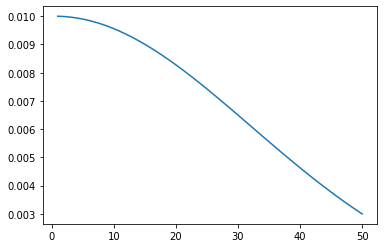

In [22]:
plt.plot(epoch_list, lr_list)
plt.show()

In [23]:
# fox random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset
dataframe = pd.read_csv('ionosphere.data', header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:, 0:34]
Y = dataset[:,34]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# create model
model = Sequential()
model.add(Dense(34, input_dim=34, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
# compile model
epochs = 50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# fit the model
model.fit(X, encoded_Y, validation_split=0.33, epochs=epochs, batch_size=28, verbose=2)

Train on 235 samples, validate on 116 samples
Epoch 1/50
 - 1s - loss: 0.6813 - accuracy: 0.6468 - val_loss: 0.6380 - val_accuracy: 0.8621
Epoch 2/50
 - 0s - loss: 0.6370 - accuracy: 0.7319 - val_loss: 0.5292 - val_accuracy: 0.8276
Epoch 3/50
 - 0s - loss: 0.5585 - accuracy: 0.8213 - val_loss: 0.4757 - val_accuracy: 0.8362
Epoch 4/50
 - 0s - loss: 0.4680 - accuracy: 0.8383 - val_loss: 0.4419 - val_accuracy: 0.9224
Epoch 5/50
 - 0s - loss: 0.3844 - accuracy: 0.8681 - val_loss: 0.2779 - val_accuracy: 0.9483
Epoch 6/50
 - 0s - loss: 0.3162 - accuracy: 0.8851 - val_loss: 0.3921 - val_accuracy: 0.8879
Epoch 7/50
 - 0s - loss: 0.2755 - accuracy: 0.9106 - val_loss: 0.2269 - val_accuracy: 0.9483
Epoch 8/50
 - 0s - loss: 0.2405 - accuracy: 0.9106 - val_loss: 0.1437 - val_accuracy: 0.9569
Epoch 9/50
 - 0s - loss: 0.2437 - accuracy: 0.9106 - val_loss: 0.2217 - val_accuracy: 0.9483
Epoch 10/50
 - 0s - loss: 0.2028 - accuracy: 0.9191 - val_loss: 0.2543 - val_accuracy: 0.9224
Epoch 11/50
 - 0s - los

### Drop-based learning rate schedule

In [25]:
from keras.callbacks import LearningRateScheduler
import math

In [27]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor(1+epoch)/epochs_drop)
    return lrate
seed = 7
np.random.seed(seed)
# load dataset
dataframe = pd.read_csv('ionosphere.data', header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:, 0:34]
Y = dataset[:,34]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# create model
model = Sequential()
model.add(Dense(34, input_dim=34, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
# compile model
sgd = SGD(learning_rate=0.0, momentum=0.9, decay=0.0, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
# fit the model
model.fit(X, encoded_Y, validation_split=0.33, epochs=50, batch_size=28,callbacks=callbacks_list,  verbose=2)

Train on 235 samples, validate on 116 samples
Epoch 1/50
 - 2s - loss: 0.6809 - accuracy: 0.6511 - val_loss: 0.6252 - val_accuracy: 0.9224
Epoch 2/50
 - 0s - loss: 0.6256 - accuracy: 0.7277 - val_loss: 0.4824 - val_accuracy: 0.8793
Epoch 3/50
 - 0s - loss: 0.5197 - accuracy: 0.8213 - val_loss: 0.4360 - val_accuracy: 0.9224
Epoch 4/50
 - 0s - loss: 0.3965 - accuracy: 0.8511 - val_loss: 0.3715 - val_accuracy: 0.9138
Epoch 5/50
 - 0s - loss: 0.3103 - accuracy: 0.8894 - val_loss: 0.1614 - val_accuracy: 0.9569
Epoch 6/50
 - 0s - loss: 0.2578 - accuracy: 0.8979 - val_loss: 0.3832 - val_accuracy: 0.8276
Epoch 7/50
 - 0s - loss: 0.2194 - accuracy: 0.9277 - val_loss: 0.1249 - val_accuracy: 0.9655
Epoch 8/50
 - 0s - loss: 0.2290 - accuracy: 0.9064 - val_loss: 0.1687 - val_accuracy: 0.9741
Epoch 9/50
 - 0s - loss: 0.2012 - accuracy: 0.9191 - val_loss: 0.1660 - val_accuracy: 0.9741
Epoch 10/50
 - 0s - loss: 0.1750 - accuracy: 0.9362 - val_loss: 0.1359 - val_accuracy: 0.9828
Epoch 11/50
 - 0s - los